# CS 328 Notebook

---

## Setup

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io
import os
from tqdm import tqdm
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib as mpl
import warnings

# Ignore warnings for cleaner output
warnings.filterwarnings('ignore')


# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Set visualization styles
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("colorblind")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Create output directories if they don't exist
os.makedirs('figures', exist_ok=True)
os.makedirs('output', exist_ok=True)

## Basic Functions

In [13]:
# Function to read WID CSV files with proper parameters
def read_wid_csv(file_path):
    """
    Read WID CSV files using the semicolon separator as specified in documentation.
    """
    try:
        return pd.read_csv(file_path, sep=';', encoding='utf-8')
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

# Function to list available files in the WID data directory
def list_wid_files(directory='wid_all_data'):
    """List and categorize files in the WID data directory."""
    if not os.path.exists(directory):
        print(f"Directory {directory} not found")
        return None
    
    all_files = os.listdir(directory)
    
    # Categorize files
    country_file = [f for f in all_files if f == 'WID_countries.csv']
    data_files = sorted([f for f in all_files if f.startswith('WID_data_')])
    metadata_files = sorted([f for f in all_files if f.startswith('WID_metadata_')])
    other_files = [f for f in all_files if f not in country_file + data_files + metadata_files]
    
    # Create a summary dictionary
    file_summary = {
        'country_file': country_file,
        'data_files': data_files,
        'metadata_files': metadata_files,
        'other_files': other_files,
        'total_files': len(all_files),
        'total_countries': len(data_files)
    }
    
    return file_summary

# Explore available countries and their metadata
def explore_countries(directory='wid_all_data'):
    """Load and explore country data from WID_countries.csv.
       Returns a summary of regions and countries.    
    """
    countries_path = os.path.join(directory, 'WID_countries.csv')
    
    if not os.path.exists(countries_path):
        print(f"Country file not found at {countries_path}")
        return None
    
    countries_df = read_wid_csv(countries_path)
    
    if countries_df is not None:
        # Create a summary of regions
        region_counts = countries_df['region'].value_counts()
        region2_counts = countries_df['region2'].value_counts()
        
        # Filter actual countries (2-letter codes) from regions/aggregates
        countries_only = countries_df[countries_df['alpha2'].str.len() == 2]
        
        # Create a country summary
        country_summary = {
            'total_entries': len(countries_df),
            'country_count': len(countries_only),
            'regions': region_counts.to_dict(),
            'subregions': region2_counts.to_dict()
        }
        
        return {
            'countries_df': countries_df,
            'summary': country_summary
        }
    
    return None

# Function to explore the structure of a single country's data file
def explore_country_data(country_code, directory='wid_all_data'):
    """
    Explore the data structure for a single country.
    
    Args:
        country_code (str): Two-letter country code (e.g., 'US', 'FR')
        directory (str): Path to the WID data directory
    
    Returns:
        dict: Summary information about the country's data
        Contains data_df, metadata_df, data_summary, and metadata_summary
    """
    data_path = os.path.join(directory, f'WID_data_{country_code}.csv')
    metadata_path = os.path.join(directory, f'WID_metadata_{country_code}.csv')
    
    if not os.path.exists(data_path) or not os.path.exists(metadata_path):
        print(f"Data or metadata file for {country_code} not found")
        return None
    
    # Load data and metadata
    data_df = read_wid_csv(data_path)
    metadata_df = read_wid_csv(metadata_path)
    
    if data_df is None or metadata_df is None:
        return None
    
    # Create data summary
    data_summary = {
        'rows': len(data_df),
        'variables': data_df['variable'].nunique(),
        'variable_list': sorted(data_df['variable'].unique()),
        'percentiles': data_df['percentile'].nunique(),
        'percentile_list': sorted(data_df['percentile'].unique()),
        'years': {
            'min': data_df['year'].min(),
            'max': data_df['year'].max(),
            'count': data_df['year'].nunique()
        }
    }
    
    # Create metadata summary
    metadata_summary = {
        'rows': len(metadata_df),
        'unique_variables': metadata_df['variable'].nunique(),
        'variable_list': sorted(metadata_df['variable'].unique())
    }
    
    return {
        'data_df': data_df,
        'metadata_df': metadata_df,
        'data_summary': data_summary,
        'metadata_summary': metadata_summary
    }

# Function to extract variable descriptions from metadata
def get_variable_descriptions(metadata_df):
    """
    Extract unique variable descriptions from metadata.
    
    Args:
        metadata_df (pd.DataFrame): Metadata dataframe
    
    Returns:
        pd.DataFrame: Dataframe with variable codes and descriptions
    """
    if metadata_df is None:
        return None
    
    # Check if required columns exist
    required_columns = ['variable', 'age', 'pop', 'shortname', 'simpledes', 'technicaldes', 'longtype', 'shortpop', 'longpop', 'shortage', 'longage', 'unit']
    if not all(col in metadata_df.columns for col in required_columns):
        print(f"Metadata is missing required columns. Available columns: {metadata_df.columns.tolist()}")
        return None
    
    # Extract unique variable descriptions
    var_descriptions = metadata_df[required_columns].drop_duplicates()
    print(f"Variable Descriptions DataFrame:\n{var_descriptions.sort_values('variable').reset_index(drop=True).head()}")
    return var_descriptions.sort_values('variable').reset_index(drop=True)

# Function to examine variable availability across countries
def compare_variable_availability(country_list, directory='wid_all_data'):
    """
    Compare which variables are available across multiple countries.
    
    Args:
        country_list (list): List of country codes to compare
        directory (str): Path to WID data directory
    
    Returns:
        pd.DataFrame: Data frame showing variable availability by country
        pd.DataFrame: Pivot table of variable availability
    """
    availability_data = []
    
    for country in country_list:
        data_path = os.path.join(directory, f'WID_data_{country}.csv')
        
        if os.path.exists(data_path):
            data_df = read_wid_csv(data_path)
            
            if data_df is not None:
                variables = data_df['variable'].unique()
                
                for var in variables:
                    # Check year range for this variable
                    var_data = data_df[data_df['variable'] == var]
                    year_min = var_data['year'].min()
                    year_max = var_data['year'].max()
                    
                    availability_data.append({
                        'country': country,
                        'variable': var,
                        'available': True,
                        'year_min': year_min,
                        'year_max': year_max,
                        'year_count': var_data['year'].nunique()
                    })
    
    # Convert to DataFrame
    availability_df = pd.DataFrame(availability_data)
    
    # print(f"Availability DataFrame:\n{availability_df.head()}")
    # Create a pivot table of availability
    if not availability_df.empty:
        pivot_df = pd.pivot_table(
            availability_df, 
            values='available',
            index='variable',
            columns='country',
            aggfunc=lambda x: True if len(x) > 0 else False,
            fill_value=False
        )
        
        # print(f"Pivot Table:\n{pivot_df.head()}")
        # Add a total count column
        pivot_df['total_countries'] = pivot_df.sum(axis=1)
        
        # Sort by availability
        pivot_df = pivot_df.sort_values('total_countries', ascending=False)
        
        return availability_df, pivot_df
    
    return None


# Main execution to explore the dataset
def explore_dataset(directory='wid_all_data'):
    """Main function to explore the WID dataset structure."""
    print("Exploring WID dataset structure...")
    
    # List available files
    files = list_wid_files(directory)
    if files:
        print(f"Total files: {files['total_files']}")
        print(f"Country files: {len(files['data_files'])}")
        
        # Show some example countries
        if files['data_files']:
            print("Example countries:", [f.replace('WID_data_', '').replace('.csv', '') 
                                         for f in files['data_files'][:10]])
    
    # Explore countries metadata
    countries_info = explore_countries(directory)
    if countries_info:
        countries_df = countries_info['countries_df']
        print(f"\nTotal countries/regions: {len(countries_df)}")
        
        # Display regions
        print("\nWorld regions:")
        for region, count in countries_info['summary']['regions'].items():
            print(f"  {region}: {count} entries")
    
    # Explore a sample country
    sample_country = 'US'  # United States as example
    country_info = explore_country_data(sample_country, directory)
    
    if country_info:
        print(f"\nSample data for {sample_country}:")
        # print(f"  Data Summary: {country_info['data_summary']}")
        # print(f"  Metadata Summary: {country_info['metadata_summary']}")
        print(f"  Rows: {country_info['data_summary']['rows']}")
        print(f"  Unique variables: {country_info['data_summary']['variables']}")
        print(f"  Year range: {country_info['data_summary']['years']['min']} - {country_info['data_summary']['years']['max']}")
        
        # Show some variable descriptions
        var_desc = get_variable_descriptions(country_info['metadata_df'])
        if var_desc is not None and len(var_desc) > 0:
            print("\nSample variable descriptions:")
            for _, row in var_desc.head(5).iterrows():
                print(f"  {row['variable']}: {row['longtype']} ({row['unit']})")
    
    return {
        'files': files,
        'countries_info': countries_info,
        'sample_country_info': country_info
    }


---

## Data Creation

In [ ]:
# Key variables we'll be using based on what's available for all countries
# These variables are confirmed to exist for all countries in our analysis

# Income variables
INCOME_SHARE_VARIABLES = ['sptincj992']  # Share of pre-tax national income with equal-split adults
INCOME_GINI_VARIABLES = ['gptincj992']   # Gini coefficient for pre-tax income
INCOME_AVERAGE_VARIABLES = ['aptincj992', 'bptincj992']  # Average metrics for pre-tax income

# anninci992 anninci999 - nninc net national income

# Wealth variables
WEALTH_SHARE_VARIABLES = ['shwealj992']  # Share of household wealth with equal-split adults
WEALTH_GINI_VARIABLES = ['ghwealj992']   # Gini coefficient for household wealth
WEALTH_AVERAGE_VARIABLES = ['bhwealj992', 'ahwealj992']  # Average metrics for household wealth

# Combined lists for easier processing
SHARE_VARIABLES = INCOME_SHARE_VARIABLES + WEALTH_SHARE_VARIABLES
GINI_VARIABLES = INCOME_GINI_VARIABLES + WEALTH_GINI_VARIABLES
AVERAGE_VARIABLES = INCOME_AVERAGE_VARIABLES + WEALTH_AVERAGE_VARIABLES

# Define combined variables for use in functions that expect INCOME_VARIABLES and WEALTH_VARIABLES
INCOME_VARIABLES = INCOME_SHARE_VARIABLES + INCOME_GINI_VARIABLES + INCOME_AVERAGE_VARIABLES
WEALTH_VARIABLES = WEALTH_SHARE_VARIABLES + WEALTH_GINI_VARIABLES + WEALTH_AVERAGE_VARIABLES

# Define percentiles of interest
TOP_PERCENTILES = ['p99p100', 'p90p100']  # Top 1%, Top 10%
BOTTOM_PERCENTILES = ['p0p50']  # Bottom 50%
MIDDLE_PERCENTILES = ['p50p90']  # Middle 40%

# Countries to include in our analysis
# We'll select a diverse set of countries from different regions and development levels
COUNTRIES_TO_ANALYZE = [
    # High-income countries
    'US',   # United States
    'FR',   # France
    'DE',   # Germany
    'GB',   # United Kingdom
    'JP',   # Japan
    
    # Upper-middle income countries
    'BR',   # Brazil
    'CN',   # China
    'RU',   # Russia
    'ZA',   # South Africa
    
    # Lower-middle and low-income countries
    'IN',   # India
    'ID',   # Indonesia
    'NG',   # Nigeria
    'EG'    # Egypt
]

# Function to load country data with selected variables
def load_country_data(country_code, directory='wid_all_data'):
    """
    Load specific inequality variables for a given country.
    
    Args:
        country_code (str): Two-letter country code
        directory (str): Path to WID data directory
    
    Returns:
        tuple: (data_df, metadata_df) for the country
    """
    data_path = os.path.join(directory, f'WID_data_{country_code}.csv')
    metadata_path = os.path.join(directory, f'WID_metadata_{country_code}.csv')
    
    if not os.path.exists(data_path) or not os.path.exists(metadata_path):
        print(f"Data or metadata not found for {country_code}")
        return None, None
    
    data_df = read_wid_csv(data_path)
    metadata_df = read_wid_csv(metadata_path)
    
    return data_df, metadata_df


## Testing

In [ ]:
# Function to create a dataset for a specific inequality metric
def create_inequality_dataset(countries, variable_codes, percentiles, directory='wid_all_data'):
    """
    Create a dataset comparing specific inequality variables across countries.
    Will try each variable code in the list until one works.
    
    Args:
        countries (list): List of country codes
        variable_codes (list or str): WID variable code(s) to try
        percentiles (list): List of percentile codes (e.g., ['p99p100', 'p0p50'])
        directory (str): Path to WID data directory
    
    Returns:
        pd.DataFrame: Combined dataset with inequality data
    """
    # Convert single variable code to list for consistent processing
    if isinstance(variable_codes, str):
        variable_codes = [variable_codes]    
    # Load country information for names
    countries_info = explore_countries(directory)
    countries_df = countries_info['countries_df']
    country_name_map = dict(zip(countries_df['alpha2'], countries_df['shortname']))
    
    # Try each variable code until we find one that works
    for variable_code in variable_codes:
        print(f"Trying variable code: {variable_code}")
        combined_df = pd.DataFrame()
        
        for country in countries:
            data_df, metadata_df = load_country_data(country, directory)
            
            if data_df is None:
                print(f"  Skipping {country} - could not load data")
                continue
            
            # Filter for the requested variable and percentiles
            filtered_df = data_df[(data_df['variable'] == variable_code) & 
                                (data_df['percentile'].isin(percentiles))]
            
            if filtered_df.empty:
                print(f"  No data for {variable_code} with percentiles {percentiles} in {country}")
                continue
            
            # Add country name
            filtered_df['country_code'] = country
            filtered_df['country_name'] = country_name_map.get(country, country)
            
            # Append to combined dataset
            combined_df = pd.concat([combined_df, filtered_df])
            print(f"  Found data for {variable_code} for {country}: {len(filtered_df)} rows")
        
        if not combined_df.empty:
            print(f"Successfully found data for variable {variable_code}")
            return combined_df
    
    print(f"No data found for any of these variables: {variable_codes} across specified countries and percentiles")
    return None

In [ ]:

# Function to create a comparative dataset of income/wealth distribution over time
def create_time_series_dataset(variable_codes, percentile, countries=COUNTRIES_TO_ANALYZE, directory='wid_all_data'):
    """
    Create a dataset of inequality metrics over time for multiple countries.
    Will try multiple variable codes until one works.
    
    Args:
        variable_codes (list or str): WID variable code(s) to try
        percentile (str): Percentile code
        countries (list): List of country codes
        directory (str): Path to WID data directory
    
    Returns:
        pd.DataFrame: Time series data for the specified variable and percentile
    """
    # Convert single variable code to list for consistent processing
    if isinstance(variable_codes, str):
        variable_codes = [variable_codes]
    
    # Get variable description (try to get from first variable code, but not critical)
    variable_desc = None
    try:
        sample_country = countries[0]
        _, metadata_df = load_country_data(sample_country, directory)
        
        if metadata_df is not None:
            for var_code in variable_codes:
                var_info = metadata_df[metadata_df['variable'] == var_code]
                if not var_info.empty:
                    variable_desc = var_info.iloc[0]['simpledes']
                    break
    except:
        pass
    
    # Try to create dataset with any of the provided variable codes
    dataset = create_inequality_dataset(countries, variable_codes, [percentile], directory)
    
    if dataset is not None:
        # Pivot to have years as columns and countries as rows for easier plotting
        dataset = dataset.sort_values(['country_name', 'year'])
        
        # Add metadata
        dataset.attrs['variable_code'] = dataset['variable'].iloc[0]  # Use the actual variable code that worked
        dataset.attrs['variable_desc'] = variable_desc
        dataset.attrs['percentile'] = percentile
    
    return dataset

# Function to create a dataset for GDP per capita
def create_gdp_dataset(countries=COUNTRIES_TO_ANALYZE, directory='wid_all_data'):
    """
    Create a dataset of GDP per capita for comparison with inequality metrics.
    Using national income per adult as a proxy.
    
    Args:
        countries (list): List of country codes
        directory (str): Path to WID data directory
    
    Returns:
        pd.DataFrame: GDP per capita data
    """
    # Try several possible GDP/income per adult variables
    gdp_variables = ['anninc992i', 'aptinc992i', 'adiinci992', 'adiincf992']
    
    # We don't need a percentile for this aggregate measure, but WID still requires one
    # p0p100 represents the entire population
    gdp_data = create_inequality_dataset(countries, gdp_variables, ['p0p100'], directory)
    
    if gdp_data is not None:
        # Add variable description
        var_code = gdp_data['variable'].iloc[0]
        gdp_data.attrs['variable_desc'] = f'Income per Adult ({var_code})'
        
        # Convert to common currency (USD) using most recent PPP rates
        # This would require additional implementation to get PPP conversion rates
        # For simplicity, we'll leave the values in local currency
    
    return gdp_data

# Function to create a cross-sectional dataset with the available variables
def create_cross_sectional_dataset(countries=COUNTRIES_TO_ANALYZE, year=2020, directory='wid_all_data'):
    """
    Create a cross-sectional dataset combining multiple inequality metrics for a specific year.
    Adapts to find available variables in the dataset.
    
    Args:
        countries (list): List of country codes
        year (int): Reference year for the cross-section
        directory (str): Path to WID data directory
    
    Returns:
        pd.DataFrame: Combined dataset with multiple inequality metrics
    """
    print("Building cross-sectional dataset with available metrics...")
    
    # Initialize results dataframe with country codes
    countries_info = explore_countries(directory)
    country_name_map = {}
    
    if countries_info is not None and 'countries_df' in countries_info:
        countries_df = countries_info['countries_df']
        country_name_map = dict(zip(countries_df['alpha2'], countries_df['shortname']))
    
    # Create the base dataframe with country information
    result_df = pd.DataFrame({
        'country_code': countries,
        'country_name': [country_name_map.get(c, c) for c in countries]
    })
    
    # Identify what variables we have available from our time series datasets
    available_datasets = []
    
    # Try loading income variables for different percentiles
    for percentile in TOP_PERCENTILES + BOTTOM_PERCENTILES:
        for var_prefix in ['a', 's']:  # Try both average and share variables
            for var_type in INCOME_VARIABLES:
                # Only use the variable type part (e.g., 'ptincf992' from 'aptincf992')
                var_base = var_type[1:] if var_type.startswith('a') or var_type.startswith('s') else var_type
                test_var = f"{var_prefix}{var_base}"
                
                dataset = create_inequality_dataset(countries, [test_var], [percentile], directory)
                if dataset is not None and not dataset.empty:
                    metric_name = f"{var_prefix}_{var_base}_{percentile}"
                    available_datasets.append({
                        'name': metric_name,
                        'dataset': dataset,
                        'variable': test_var,
                        'percentile': percentile
                    })
                    print(f"  Found data for {test_var} with percentile {percentile}")
    
    # Try loading wealth variables
    for percentile in TOP_PERCENTILES + BOTTOM_PERCENTILES:
        for wealth_var in WEALTH_VARIABLES:
            dataset = create_inequality_dataset(countries, [wealth_var], [percentile], directory)
            if dataset is not None and not dataset.empty:
                metric_name = f"{wealth_var}_{percentile}"
                available_datasets.append({
                    'name': metric_name,
                    'dataset': dataset,
                    'variable': wealth_var,
                    'percentile': percentile
                })
                print(f"  Found data for {wealth_var} with percentile {percentile}")
    
    # Try loading GDP or income per adult variables
    gdp_data = create_gdp_dataset(countries, directory)
    if gdp_data is not None and not gdp_data.empty:
        var_code = gdp_data['variable'].iloc[0]
        available_datasets.append({
            'name': f"{var_code}_per_adult",
            'dataset': gdp_data,
            'variable': var_code,
            'percentile': 'p0p100'
        })
        print(f"  Found GDP/income per adult data: {var_code}")
    
    # Extract values for the reference year (or closest available)
    for dataset_info in available_datasets:
        df = dataset_info['dataset']
        name = dataset_info['name']
        
        # Initialize new columns with NaN
        result_df[f"{name}_value"] = np.nan
        result_df[f"{name}_year"] = np.nan
        
        # Process each country
        for country in result_df['country_code']:
            country_data = df[df['country_code'] == country]
            
            if not country_data.empty:
                # Try to get the exact year first
                year_data = country_data[country_data['year'] == year]
                
                # If exact year not available, find closest year
                if year_data.empty:
                    available_years = country_data['year'].unique()
                    if len(available_years) > 0:
                        closest_year = available_years[np.abs(available_years - year).argmin()]
                        year_data = country_data[country_data['year'] == closest_year]
                
                # If we found data, add it to the result
                if not year_data.empty:
                    row_idx = result_df[result_df['country_code'] == country].index[0]
                    result_df.loc[row_idx, f"{name}_value"] = year_data['value'].iloc[0]
                    result_df.loc[row_idx, f"{name}_year"] = year_data['year'].iloc[0]
    
    # Add region information if available
    if countries_info is not None and 'countries_df' in countries_info:
        countries_df = countries_info['countries_df']
        
        for idx, row in result_df.iterrows():
            country_info = countries_df[countries_df['alpha2'] == row['country_code']]
            if not country_info.empty:
                result_df.loc[idx, 'region'] = country_info['region'].iloc[0]
                result_df.loc[idx, 'region2'] = country_info['region2'].iloc[0]
    
    # Display summary of metrics found
    value_cols = [col for col in result_df.columns if col.endswith('_value')]
    print(f"Created cross-sectional dataset with {len(value_cols)} metrics for {len(result_df)} countries")
    
    return result_df

# Function to create a dataset comparing changes in inequality over time
def create_inequality_change_dataset(countries=COUNTRIES_TO_ANALYZE, 
                                     variable_codes=INCOME_VARIABLES,
                                     percentile='p99p100', 
                                     start_year=1980, 
                                     end_year=2020,
                                     directory='wid_all_data'):
    """
    Create a dataset showing changes in inequality metrics over time.
    
    Args:
        countries (list): List of country codes
        variable_codes (list or str): WID variable code(s) to try
        percentile (str): Percentile code
        start_year (int): Starting year for change calculation
        end_year (int): Ending year for change calculation
        directory (str): Path to WID data directory
    
    Returns:
        pd.DataFrame: Dataset with inequality changes
    """
    # Get the time series data
    time_series = create_time_series_dataset(variable_codes, percentile, countries, directory)
    
    if time_series is None:
        return None
    
    # Calculate changes
    change_data = []
    
    # Group by country
    for country, group in time_series.groupby('country_code'):
        group = group.sort_values('year')
        country_name = group['country_name'].iloc[0]
        
        # Try to get values for exact years
        start_data = group[group['year'] == start_year]
        end_data = group[group['year'] == end_year]
        
        # If exact years not available, find closest years
        if start_data.empty:
            available_years = group['year'].unique()
            closest_start = available_years[np.abs(available_years - start_year).argmin()]
            start_data = group[group['year'] == closest_start]
        
        if end_data.empty:
            available_years = group['year'].unique()
            closest_end = available_years[np.abs(available_years - end_year).argmin()]
            end_data = group[group['year'] == closest_end]
        
        # Skip if we don't have data for both periods
        if start_data.empty or end_data.empty:
            print(f"Insufficient data for {country} to calculate changes")
            continue
        
        # Calculate changes
        start_value = start_data['value'].iloc[0]
        end_value = end_data['value'].iloc[0]
        actual_start_year = start_data['year'].iloc[0]
        actual_end_year = end_data['year'].iloc[0]
        
        absolute_change = end_value - start_value
        percent_change = (absolute_change / start_value) * 100 if start_value != 0 else np.nan
        
        change_data.append({
            'country_code': country,
            'country_name': country_name,
            'start_year': actual_start_year,
            'end_year': actual_end_year,
            'start_value': start_value,
            'end_value': end_value,
            'absolute_change': absolute_change,
            'percent_change': percent_change
        })
    
    # Convert to DataFrame
    change_df = pd.DataFrame(change_data)
    
    if change_df.empty:
        return None
    
    # Add metadata
    change_df.attrs['variable_code'] = time_series.attrs.get('variable_code', '')
    change_df.attrs['variable_desc'] = time_series.attrs.get('variable_desc', '')
    change_df.attrs['percentile'] = percentile
    
    return change_df

# Function to combine income and wealth inequality data for correlation analysis
def create_correlation_dataset(countries=COUNTRIES_TO_ANALYZE, reference_year=2020, directory='wid_all_data'):
    """
    Create a dataset to analyze correlations between income and wealth inequality.
    
    Args:
        countries (list): List of country codes
        reference_year (int): Reference year for the cross-section
        directory (str): Path to WID data directory
    
    Returns:
        pd.DataFrame: Dataset with income and wealth inequality metrics
    """
    # Get cross-sectional data
    cross_section = create_cross_sectional_dataset(countries, reference_year, directory)
    
    if cross_section is None or cross_section.empty:
        print("Could not create cross-sectional dataset for correlation analysis")
        return None
    
    # Create metrics for correlation analysis
    corr_metrics = [
        ('top1_income_share', 'top1_wealth_share'),
        ('top10_income_share', 'top10_wealth_share'),
        ('bottom50_income_share', 'bottom50_wealth_share'),
        ('gdp_per_adult', 'top1_income_share'),
        ('gdp_per_adult', 'top1_wealth_share')
    ]
    
    # Calculate correlations
    correlations = {}
    
    for x_var, y_var in corr_metrics:
        if x_var in cross_section.columns and y_var in cross_section.columns:
            # Filter out NaN values
            valid_data = cross_section[[x_var, y_var]].dropna()
            
            if len(valid_data) >= 5:  # Require at least 5 countries for meaningful correlation
                corr, p_value = stats.pearsonr(valid_data[x_var], valid_data[y_var])
                correlations[f'{x_var}_vs_{y_var}'] = {
                    'correlation': corr,
                    'p_value': p_value,
                    'n': len(valid_data)
                }
    
    # Add correlations to dataset attributes
    cross_section.attrs['correlations'] = correlations
    
    return cross_section

# Main function to prepare all datasets
def prepare_all_datasets(directory='wid_all_data'):
    """
    Prepare all datasets needed for our inequality analysis with a focus on
    comparing wealth and income inequality patterns across countries.
    
    Args:
        directory (str): Path to WID data directory
    
    Returns:
        dict: Dictionary of prepared datasets
    """
    print("Preparing inequality datasets...")
    
    datasets = {}
    
    # 1. Income share datasets for different percentiles
    for percentile in TOP_PERCENTILES + BOTTOM_PERCENTILES:
        print(f"Creating income share dataset for {percentile}...")
        datasets[f'income_share_{percentile}'] = create_time_series_dataset(
            INCOME_SHARE_VARIABLES, percentile, COUNTRIES_TO_ANALYZE, directory)
    
    # 2. Wealth share datasets for different percentiles
    for percentile in TOP_PERCENTILES + BOTTOM_PERCENTILES:
        print(f"Creating wealth share dataset for {percentile}...")
        datasets[f'wealth_share_{percentile}'] = create_time_series_dataset(
            WEALTH_SHARE_VARIABLES, percentile, COUNTRIES_TO_ANALYZE, directory)
    
    # 3. Income and wealth Gini coefficients (overall inequality metrics)
    print("Creating income Gini coefficient dataset...")
    datasets['income_gini'] = create_time_series_dataset(
        INCOME_GINI_VARIABLES, 'p0p100', COUNTRIES_TO_ANALYZE, directory)
    
    print("Creating wealth Gini coefficient dataset...")
    datasets['wealth_gini'] = create_time_series_dataset(
        WEALTH_GINI_VARIABLES, 'p0p100', COUNTRIES_TO_ANALYZE, directory)
    
    # 4. Average income and wealth metrics (for development level comparison)
    print("Creating average income dataset...")
    datasets['average_income'] = create_time_series_dataset(
        INCOME_AVERAGE_VARIABLES, 'p0p100', COUNTRIES_TO_ANALYZE, directory)
    
    print("Creating average wealth dataset...")
    datasets['average_wealth'] = create_time_series_dataset(
        WEALTH_AVERAGE_VARIABLES, 'p0p100', COUNTRIES_TO_ANALYZE, directory)
    
    # 5. Cross-sectional dataset with the latest data for all metrics
    print("Creating cross-sectional dataset...")
    datasets['cross_section'] = create_cross_sectional_dataset(
        COUNTRIES_TO_ANALYZE, 2020, directory)
    
    # 6. Calculate wealth-to-income inequality ratios for cross-sectional analysis
    if datasets['cross_section'] is not None and not datasets['cross_section'].empty:
        print("Calculating wealth-to-income inequality ratios...")
        calculate_wealth_income_ratios(datasets['cross_section'])
    
    # 7. Calculate changes in inequality metrics over time
    print("Creating inequality change datasets...")
    for metric_type in ['income_share', 'wealth_share', 'income_gini', 'wealth_gini']:
        percentile = 'p99p100' if 'share' in metric_type else 'p0p100'
        variable_list = INCOME_SHARE_VARIABLES if metric_type == 'income_share' else \
                       WEALTH_SHARE_VARIABLES if metric_type == 'wealth_share' else \
                       INCOME_GINI_VARIABLES if metric_type == 'income_gini' else \
                       WEALTH_GINI_VARIABLES
        
        datasets[f'{metric_type}_change'] = create_inequality_change_dataset(
            COUNTRIES_TO_ANALYZE, variable_list, percentile, 1980, 2020, directory)
    
    # 8. Development level dataset (using average income as proxy)
    print("Creating development level dataset...")
    datasets['development_level'] = create_time_series_dataset(
        INCOME_AVERAGE_VARIABLES, 'p0p100', COUNTRIES_TO_ANALYZE, directory)
    
    # Save datasets to CSV files
    output_dir = 'output'
    os.makedirs(output_dir, exist_ok=True)
    
    for name, df in datasets.items():
        if df is not None and not df.empty:
            df.to_csv(os.path.join(output_dir, f'{name}.csv'), index=False)
            print(f"Saved {name}.csv")
    
    print("Dataset preparation complete!")
    return datasets

# Function to calculate wealth-to-income inequality ratios
def calculate_wealth_income_ratios(cross_section_df):
    """
    Calculate wealth-to-income inequality ratios for cross-sectional analysis.
    Adds these ratios directly to the dataframe.
    
    Args:
        cross_section_df (pd.DataFrame): Cross-sectional dataset with inequality metrics
    
    Returns:
        None (modifies dataframe in-place)
    """
    # Find wealth and income share columns for top percentiles
    wealth_cols = [col for col in cross_section_df.columns 
                  if col.endswith('_value') and 'wealth' in col and any(p in col for p in TOP_PERCENTILES)]
    
    income_cols = [col for col in cross_section_df.columns 
                  if col.endswith('_value') and 'income' in col and 'share' in col 
                  and any(p in col for p in TOP_PERCENTILES)]
    
    # Find Gini coefficient columns
    wealth_gini_cols = [col for col in cross_section_df.columns 
                       if col.endswith('_value') and 'wealth' in col and 'gini' in col]
    
    income_gini_cols = [col for col in cross_section_df.columns 
                       if col.endswith('_value') and 'income' in col and 'gini' in col]
    
    # Calculate wealth-to-income share ratios for each percentile
    for w_col in wealth_cols:
        for i_col in income_cols:
            # Make sure we're comparing the same percentile
            w_percentile = next((p for p in TOP_PERCENTILES if p in w_col), None)
            i_percentile = next((p for p in TOP_PERCENTILES if p in i_col), None)
            
            if w_percentile == i_percentile:
                ratio_name = f"wealth_to_income_ratio_{w_percentile}"
                cross_section_df[ratio_name] = cross_section_df[w_col] / cross_section_df[i_col]
                print(f"  Calculated {ratio_name}")
    
    # Calculate wealth-to-income Gini ratio if available
    if wealth_gini_cols and income_gini_cols:
        cross_section_df['wealth_to_income_gini_ratio'] = \
            cross_section_df[wealth_gini_cols[0]] / cross_section_df[income_gini_cols[0]]
        print("  Calculated wealth-to-income Gini ratio")
    
    # Group countries by development level (using average income as proxy)
    income_avg_cols = [col for col in cross_section_df.columns 
                      if col.endswith('_value') and 'income' in col and 'average' in col]
    
    if income_avg_cols:
        try:
            # Create development level categories using income levels
            income_col = income_avg_cols[0]
            
            # Remove missing values for ranking
            valid_income = cross_section_df.dropna(subset=[income_col])
            
            if len(valid_income) >= 6:  # Need at least 6 countries for 3 groups of 2
                # Create ranks, handling ties
                ranks = valid_income[income_col].rank(method='first')
                
                # Create quantiles with 3 groups if enough countries
                n_groups = min(3, len(valid_income) // 2)
                
                development_labels = [f'Low Income', f'Middle Income', f'High Income'][:n_groups]
                
                # Create development level categories
                valid_income['development_level'] = pd.qcut(
                    ranks, q=n_groups, labels=development_labels
                )
                
                # Merge back to original dataframe
                development_mapping = dict(zip(
                    valid_income['country_code'], 
                    valid_income['development_level']
                ))
                
                # Apply mapping to original dataframe
                cross_section_df['development_level'] = \
                    cross_section_df['country_code'].map(development_mapping)
                
                print("  Added development level categories")
        except Exception as e:
            print(f"  Error creating development levels: {e}")
    
    # Add region groupings based on country codes
    region_mapping = {
        'US': 'North America',
        'FR': 'Western Europe', 
        'DE': 'Western Europe',
        'GB': 'Western Europe',
        'JP': 'East Asia',
        'BR': 'Latin America',
        'CN': 'East Asia',
        'RU': 'Eastern Europe',
        'ZA': 'Africa',
        'IN': 'South Asia',
        'ID': 'Southeast Asia',
        'NG': 'Africa',
        'EG': 'Middle East & North Africa'
    }
    
    cross_section_df['region'] = cross_section_df['country_code'].map(region_mapping)
    print("  Added region classifications")

In [ ]:
prepared_data = prepare_all_datasets()

## Actual

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from linearmodels.panel import PanelOLS, RandomEffects, compare

# ---------------------------
# 1. Data Loading and Reshaping
# ---------------------------

# Define file paths (adjust as needed)
file_income_wealth = "WID_data/WID_Data_average national wealth per adult.csv"
file_wealth_inequality = "WID_data/WID_Data_Wealth_Gini_coeff.csv"
file_income_inequality = "WID_data/WID_Data_Income_Gini_coeff.csv"
file_wealth_to_income = "WID_data/WID_Data_Net national wealth to Net National Income Ratio.csv"

# Read in the datasets
df_income_wealth = pd.read_csv(file_income_wealth, header=1, sep=';')
df_wealth_inequality = pd.read_csv(file_wealth_inequality, header=1, sep=';')
df_income_inequality = pd.read_csv(file_income_inequality, header=1, sep=';')
df_wealth_to_income = pd.read_csv(file_wealth_to_income, header=1, sep=';')

# Define a function to reshape data from wide to long format
def reshape_wid(df, value_column_name):
    return df.melt(id_vars=['Percentile', 'Year'], var_name='Country', value_name=value_column_name)

# Reshape each dataset
df_income_long = reshape_wid(df_income_wealth, 'PerAdultIncome')
df_wealth_ineq_long = reshape_wid(df_wealth_inequality, 'WealthInequality')
df_income_ineq_long = reshape_wid(df_income_inequality, 'IncomeInequality')
df_wealth_to_income_long = reshape_wid(df_wealth_to_income, 'WealthToIncomeRatio')

# ---------------------------
# 2. Data Cleaning
# ---------------------------

# Convert Year to numeric
for df in [df_income_long, df_wealth_ineq_long, df_income_ineq_long, df_wealth_to_income_long]:
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce')

# Filter for consistent percentiles:
# - For Income Wealth and Wealth-to-Income, only "pall" is available.
# - For Income Inequality and Wealth Inequality, choose "pall".
df_income_long = df_income_long[df_income_long['Percentile'] == 'pall']
df_wealth_to_income_long = df_wealth_to_income_long[df_wealth_to_income_long['Percentile'] == 'pall']
df_income_ineq_long = df_income_ineq_long[df_income_ineq_long['Percentile'] == 'pall']
df_wealth_ineq_long = df_wealth_ineq_long[df_wealth_ineq_long['Percentile'] == 'pall']

# Drop the Percentile column since it is no longer needed
df_income_long = df_income_long.drop(columns=['Percentile'])
df_wealth_to_income_long = df_wealth_to_income_long.drop(columns=['Percentile'])
df_income_ineq_long = df_income_ineq_long.drop(columns=['Percentile'])
df_wealth_ineq_long = df_wealth_ineq_long.drop(columns=['Percentile'])

# Clean country names (remove extra whitespace)
for df in [df_income_long, df_wealth_ineq_long, df_income_ineq_long, df_wealth_to_income_long]:
    df['Country'] = df['Country'].str.strip()

# ---------------------------
# 3. Merge DataFrames (Inner Join on Country and Year)
# ---------------------------
df_merged = (df_income_long.merge(df_income_ineq_long, on=['Country','Year'], how='inner')
                        .merge(df_wealth_ineq_long, on=['Country','Year'], how='inner')
                        .merge(df_wealth_to_income_long, on=['Country','Year'], how='inner'))

# ---------------------------
# 4. Panel Data Analysis
# ---------------------------

# Set a MultiIndex for panel models
df_panel = df_merged.set_index(["Country", "Year"])

# Define exogenous variable with constant
exog = sm.add_constant(df_panel["PerAdultIncome"])

# a) Fixed Effects Model with robust standard errors
fe_model = PanelOLS(df_panel["IncomeInequality"], exog, entity_effects=True)
fe_results = fe_model.fit(cov_type='robust')
print("Fixed Effects Model (PanelOLS):")
print(fe_results)

# b) Random Effects Model
re_model = RandomEffects(df_panel["IncomeInequality"], exog)
re_results = re_model.fit()
print("\nRandom Effects Model:")
print(re_results)

# c) Model comparison (Hausman-type)
comparison = compare({'FE': fe_results, 'RE': re_results})
print("\nModel Comparison:")
print(comparison)

# ---------------------------
# 5. Cross-Sectional Analysis (Using data for 2020 only)
# ---------------------------
df_2020 = df_merged[df_merged["Year"] == 2020].copy()
ols_model = sm.OLS(df_2020["IncomeInequality"], sm.add_constant(df_2020["PerAdultIncome"]))
ols_results = ols_model.fit()
print("\nCross-sectional OLS (2020) results:")
print(ols_results.summary())


Fixed Effects Model (PanelOLS):
                          PanelOLS Estimation Summary                           
Dep. Variable:       IncomeInequality   R-squared:                        0.0310
Estimator:                   PanelOLS   R-squared (Between):             -0.0949
No. Observations:                1479   R-squared (Within):               0.0310
Date:                Sun, Apr 13 2025   R-squared (Overall):             -0.0871
Time:                        09:48:38   Log-likelihood                    3366.6
Cov. Estimator:                Robust                                           
                                        F-statistic:                      45.671
Entities:                          51   P-value                           0.0000
Avg Obs:                       29.000   Distribution:                  F(1,1427)
Min Obs:                       29.000                                           
Max Obs:                       29.000   F-statistic (robust):             49.

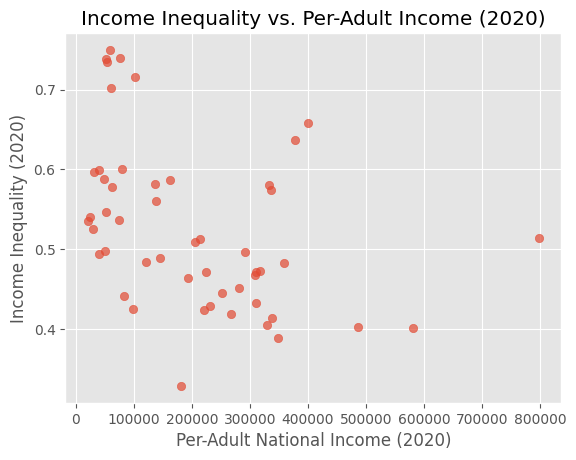

Correlation between Per-Adult Income and Income Inequality: -0.40635998320810146
                            OLS Regression Results                            
Dep. Variable:       IncomeInequality   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     9.692
Date:                Sun, 13 Apr 2025   Prob (F-statistic):            0.00309
Time:                        10:33:46   Log-Likelihood:                 48.778
No. Observations:                  51   AIC:                            -93.56
Df Residuals:                      49   BIC:                            -89.69
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

In [26]:
# Suppose you want the data for the year 2020 only
df_2020 = df_merged[df_merged['Year'] == 2020].copy()
plt.scatter(df_2020['PerAdultIncome'], df_2020['IncomeInequality'], alpha=0.7)
plt.xlabel("Per-Adult National Income (2020)")
plt.ylabel("Income Inequality (2020)")
plt.title("Income Inequality vs. Per-Adult Income (2020)")
plt.show()


# Calculate Pearson correlation
corr_h1 = df_2020['PerAdultIncome'].corr(df_2020['IncomeInequality'])
print("Correlation between Per-Adult Income and Income Inequality:", corr_h1)

# Regression model for further inspection
X = sm.add_constant(df_2020['PerAdultIncome'])
model_h1 = sm.OLS(df_2020['IncomeInequality'], X).fit()
print(model_h1.summary())

# Summary of Statistical Results

## 1. Fixed Effects Model (PanelOLS)

**Model Setup:**
- **Dependent Variable:** IncomeInequality  
- **Observations:** 1479 (51 countries × 29 time periods)  
- **Estimator:** PanelOLS with robust standard errors  
- **R-squared (Within):** 0.0310  
  *Interpretation:* About 3.1% of the within-country variation in income inequality is explained by per-adult income.
- **F-statistic:** 45.671 (robust F-statistic: 49.916, p < 0.0000)

**Parameter Estimates:**
- **Intercept (const):** 0.5080  
  - *t-statistic:* 221.71 (p < 0.0000)
- **PerAdultIncome:** 8.919e-08  
  - *t-statistic:* 7.0651 (p < 0.0000)  
  - *Interpretation:* Within each country, an increase in per-adult income is associated with a statistically significant increase in income inequality, though the effect is small in magnitude.

**Additional Note:**  
The F-test for poolability (F = 396.10, p < 0.0000) confirms that it is important to include country-specific fixed effects.

---

## 2. Random Effects Model

**Model Setup:**
- **Dependent Variable:** IncomeInequality  
- **Observations:** 1479 (same panel data)  
- **Estimator:** Random Effects  
- **R-squared (Within):** 0.0309  

**Parameter Estimates:**
- **Intercept (const):** 0.5089  
- **PerAdultIncome:** 8.33e-08  
  - *t-statistic:* 6.3315 (p < 0.0000)  
  - *Interpretation:* The random effects model also finds a positive effect of per-adult income on income inequality, similar in magnitude to the fixed effects model.

---

## 3. Model Comparison (FE vs. RE)

- **Coefficient Comparison:**  
  - FE: PerAdultIncome coefficient = 8.919e-08  
  - RE: PerAdultIncome coefficient = 8.33e-08
- **Conclusion:** Although both models produce similar estimates for the effect of per-adult income, the significant poolability test indicates that the fixed effects approach (which controls for time‑invariant country differences) is more appropriate.

---

## 4. Cross-Sectional OLS (2020 Data)

**Model Setup:**
- **Data:** 51 observations (one per country for 2020)  
- **R-squared:** 0.165 (Adj. R-squared: 0.148)  
- **F-statistic:** 9.692 (p = 0.00309)

**Parameter Estimates:**
- **Intercept (const):** 0.5791  
- **PerAdultIncome:** -2.607e-07  
  - *t-statistic:* -3.113 (p = 0.003)  
  - *Interpretation:* In the cross-sectional snapshot from 2020, higher per-adult income is significantly associated with lower income inequality across countries.

---

## Overall Interpretation

- **Within-Country (Panel) Analysis:**  
  The fixed effects model shows a **positive relationship**—as a country’s per-adult income increases over time, its income inequality tends to rise modestly, even after controlling for unobserved, time‑invariant country characteristics.

- **Between-Country (Cross-Sectional) Analysis:**  
  By contrast, the cross-sectional OLS model (using 2020 data) finds a **negative relationship**—indicating that richer countries tend to have lower income inequality at a given point in time.

- **Takeaway:**  
  These contrasting findings are not uncommon:
  - **Panel Data Results** capture within-country dynamics (how income growth relates to inequality over time within the same country).
  - **Cross-Sectional Results** capture differences across countries at one point in time (structural and institutional differences).
  
This divergence suggests that the factors driving changes in inequality within countries over time may differ from those that explain why richer countries tend to have lower inequality when compared at a single point in time.


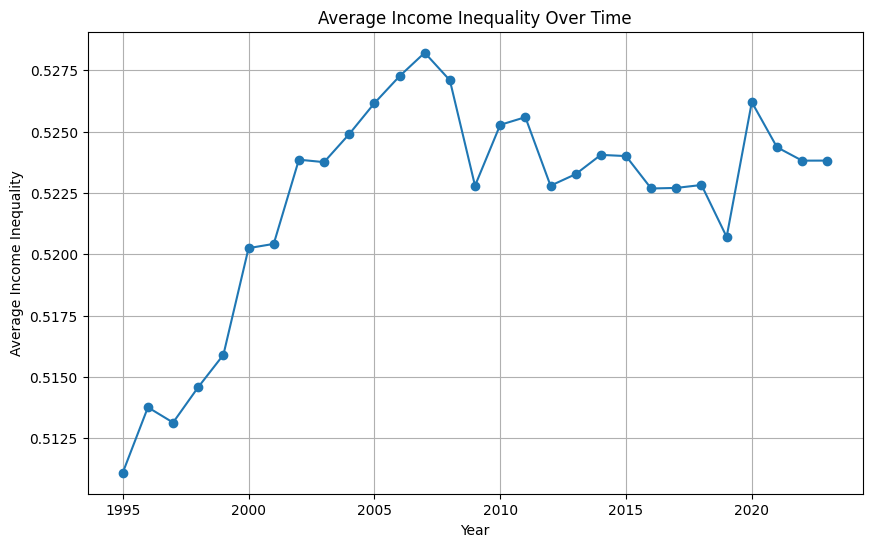

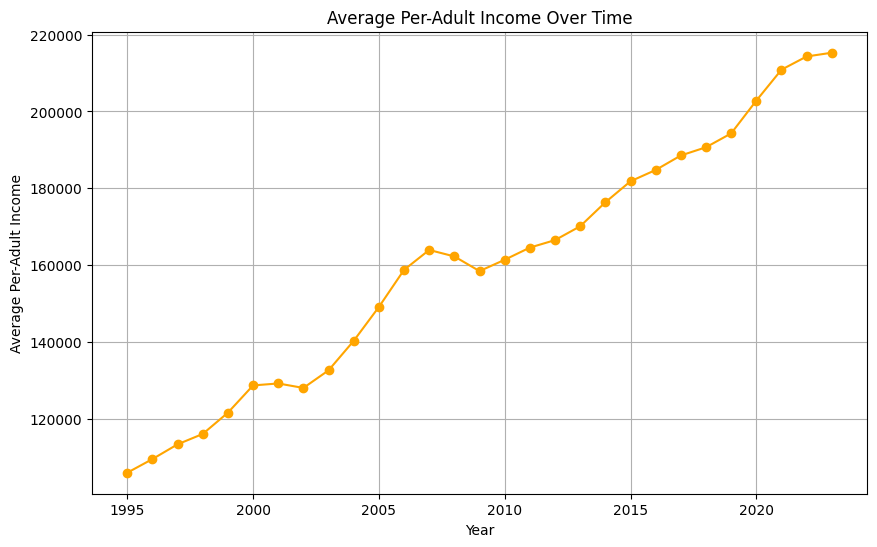

In [16]:
# Compute the average IncomeInequality per year
avg_inequality = df_merged.groupby("Year")["IncomeInequality"].mean()

plt.figure(figsize=(10, 6))
plt.plot(avg_inequality.index, avg_inequality.values, marker='o')
plt.xlabel("Year")
plt.ylabel("Average Income Inequality")
plt.title("Average Income Inequality Over Time")
plt.grid(True)
plt.show()

# Compute the average PerAdultIncome per year
avg_income = df_merged.groupby("Year")["PerAdultIncome"].mean()

plt.figure(figsize=(10, 6))
plt.plot(avg_income.index, avg_income.values, marker='o', color='orange')
plt.xlabel("Year")
plt.ylabel("Average Per-Adult Income")
plt.title("Average Per-Adult Income Over Time")
plt.grid(True)
plt.show()


# Master DataFrame

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# File paths
file_income = "WID_data/WID_Data_average_national_income.csv"
file_wealth_inequality = "WID_data/WID_Data_Wealth_Gini_coeff.csv"
file_income_inequality = "WID_data/WID_Data_Income_Gini_coeff.csv"
file_wealth_to_income = "WID_data/WID_Data_Net national wealth to Net National Income Ratio.csv"
file_GDP = "WID_data/WID_Data_GDP.csv"
file_population = "WID_data/WID_Data_Population.csv"
file_net_personal_wealth = "WID_data/WID_Data_Net_personal_wealth.csv"
file_national_income = "WID_data/WID_Data_National_income.csv"

# Read the datasets
df_income_wealth = pd.read_csv(file_income, header=1, sep=';')
df_wealth_inequality = pd.read_csv(file_wealth_inequality, header=1, sep=';')
df_income_inequality = pd.read_csv(file_income_inequality, header=1, sep=';')
df_wealth_to_income = pd.read_csv(file_wealth_to_income, header=1, sep=';')
df_GDP = pd.read_csv(file_GDP, header=1, sep=';')
df_population = pd.read_csv(file_population, header=1, sep=';')
df_net_wealth = pd.read_csv(file_net_personal_wealth, header=1, sep=';')
df_national_income = pd.read_csv(file_national_income, header=1, sep=';')

# Define a reshaping function
def reshape_wid(df, value_column_name):
    df_long = df.melt(id_vars=['Percentile', 'Year'], var_name='Country', value_name=value_column_name)
    df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce')
    df_long['Country'] = df_long['Country'].str.strip()
    
    # Prefer 'pall', else take 'p90p100'
    if 'pall' in df_long['Percentile'].unique():
        df_long = df_long[df_long['Percentile'] == 'pall']
    else:
        df_long = df_long[df_long['Percentile'] == 'p90p100']
        
    return df_long.drop(columns=['Percentile'])

# Reshape and clean all datasets
df_income_long = reshape_wid(df_income_wealth, 'PerAdultIncome')
df_wealth_ineq_long = reshape_wid(df_wealth_inequality, 'WealthInequality')
df_income_ineq_long = reshape_wid(df_income_inequality, 'IncomeInequality')
df_wealth_to_income_long = reshape_wid(df_wealth_to_income, 'WealthToIncomeRatio')
df_GDP_long = reshape_wid(df_GDP, 'GDP')
df_population_long = reshape_wid(df_population, 'Population')
df_net_wealth_long = reshape_wid(df_net_wealth, 'NetPersonalWealth')
df_national_income_long = reshape_wid(df_national_income, 'NationalIncome')

# Merge all datasets on ['Country', 'Year']
dfs_to_merge = [
    df_income_long,
    df_wealth_ineq_long,
    df_income_ineq_long,
    df_wealth_to_income_long,
    df_GDP_long,
    df_population_long,
    df_net_wealth_long,
    df_national_income_long
]

from functools import reduce
df_merged = reduce(lambda left, right: pd.merge(left, right, on=['Country', 'Year'], how='inner'), dfs_to_merge)

# Final diagnostic
print("Merged DataFrame:")
print(df_merged.head())
print("Shape:", df_merged.shape)
print("Columns:", df_merged.columns.tolist())


Merged DataFrame:
   Year    Country  PerAdultIncome  WealthInequality  IncomeInequality  \
0  1995  Argentina      72410.8213            0.6419            0.6419   
1  1996  Argentina      75215.2402            0.6419            0.6419   
2  1997  Argentina      79763.7347            0.6419            0.6419   
3  1998  Argentina      83478.5061            0.6419            0.6419   
4  1999  Argentina      80222.4259            0.6419            0.6419   

   WealthToIncomeRatio        GDP  Population  NetPersonalWealth  \
0             3.355870  3246941.8    35070020             0.6186   
1             3.358287  3383565.3    35513793             0.6186   
2             3.330600  3613854.8    35947791             0.6186   
3             3.415269  3709134.5    36372860             0.6187   
4             3.471241  3542473.8    36794682             0.6186   

   NationalIncome  
0      21577.3592  
1      22396.9085  
2      23948.7617  
3      24442.7282  
4      23110.5914  
Shape: (

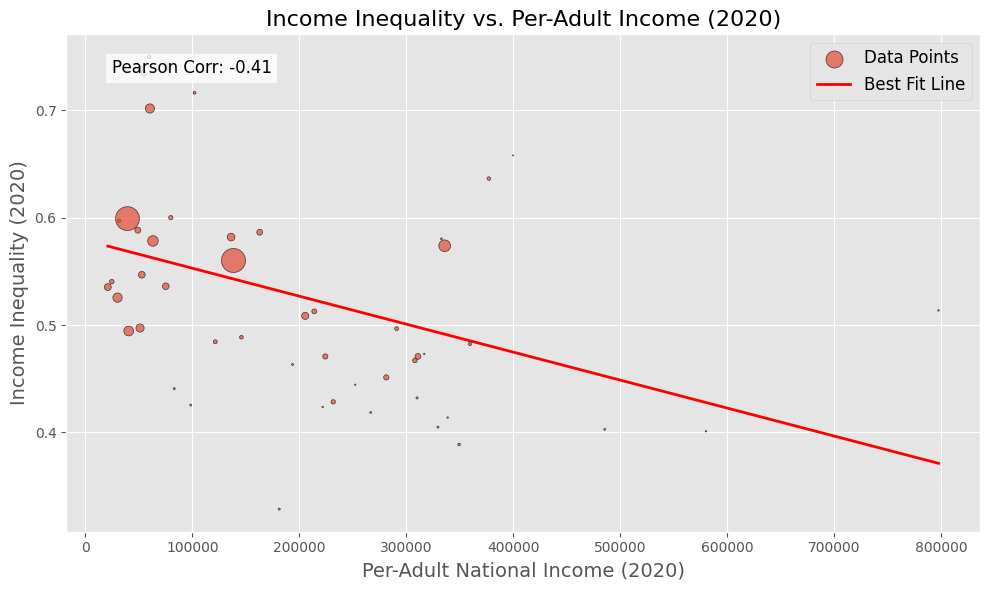

Correlation between Per-Adult Income and Income Inequality: -0.40635998320810146
                            OLS Regression Results                            
Dep. Variable:       IncomeInequality   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     9.692
Date:                Sun, 13 Apr 2025   Prob (F-statistic):            0.00309
Time:                        10:36:39   Log-Likelihood:                 48.778
No. Observations:                  51   AIC:                            -93.56
Df Residuals:                      49   BIC:                            -89.69
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

# Use a pleasant style for the plot
plt.style.use('ggplot')

# Suppose df_2020 is already defined (data for the year 2020) and contains a "Population" column.
# For demonstration, the column names used are:
# 'PerAdultIncome', 'IncomeInequality', and 'Population'

plt.figure(figsize=(10, 6))

# Scale the population values to determine dot sizes.
# Here, we normalize the Population to the maximum value and multiply by a scaling factor (e.g., 300).
population = df_2020['Population']
marker_sizes = (population / population.max()) * 300

# Create scatter plot with bubble sizes based on population
plt.scatter(df_2020['PerAdultIncome'], df_2020['IncomeInequality'],
            s=marker_sizes, alpha=0.7, edgecolor='k', label='Data Points')

# Regression line: calculate the best-fit line using np.polyfit
x = df_2020['PerAdultIncome']
y = df_2020['IncomeInequality']
sorted_idx = np.argsort(x)
x_sorted = x.iloc[sorted_idx]
m, b = np.polyfit(x, y, 1)
y_fit = m * x_sorted + b
plt.plot(x_sorted, y_fit, color='red', linewidth=2, label='Best Fit Line')

# Calculate Pearson correlation coefficient and annotate the plot.
corr_h1 = x.corr(y)
plt.text(0.05, 0.95, f'Pearson Corr: {corr_h1:.2f}', transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# Set axis labels, title, legend, and grid enhancements.
plt.xlabel("Per-Adult National Income (2020)", fontsize=14)
plt.ylabel("Income Inequality (2020)", fontsize=14)
plt.title("Income Inequality vs. Per-Adult Income (2020)", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate and print Pearson correlation
print("Correlation between Per-Adult Income and Income Inequality:", corr_h1)

# Build and display the OLS regression model summary for further inspection.
X = sm.add_constant(df_2020['PerAdultIncome'])
model_h1 = sm.OLS(df_2020['IncomeInequality'], X).fit()
print(model_h1.summary())
